- добавить комментарии к ячейкам
- оформить все

Задание из видео Карпова [Разбор тестового задания на позицию junior аналитика данных](https://www.youtube.com/watch?v=3VWDh-gdiYg)   22:09

Описание данных:  
orders - таблица с информацией о заказах;  
order_id - уникальный идентификатор заказа;  
customer_id - уникальный идентификатор клиента;  
order_date - дата, когда заказ был создан;  
order_amount - cумма заказа;  
platform - платформа, через которую был сделан заказ (например, 'mobile', 'desktop');  
category - категория товара, который был заказан (например, 'smartphones', 'laptops').

1. Построй когортый анализ: выдели клиентов, совершивших первую покупку в течение определенного месяца (когортную дату) и вычисли размер каждой когорты.  
2. Рассчитай средний доход с клиента для каждой когорты за 10 дней с момента их первой покупки.  
3. Отобрази результаты по месяцам первых покупок, категориям товаров и платформам.  

Вывод должен содержать следующие поля:
- дата когорты;
- платформа;
- категория товара;
- размер когорты;
- средний доход с клиента.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(style='whitegrid', palette='pastel')

In [3]:
customer_ids = np.array([])
ids = []
for i in range(1, 1001):
    ids.append(i)
    customer_ids = np.append(customer_ids, np.random.choice(ids, (1, i // 50 + 1)))

In [4]:
customer_ids = customer_ids.astype(int)

In [5]:
# число заказов
N = customer_ids.size

In [6]:
order_dates = pd.date_range('2023-01-01', '2024-02-01', periods=N)

In [7]:
order_amounts = 111 + np.random.exponential(1, N) * 10000

In [8]:
platforms = np.random.choice(['mobile', 'desktop', 'shop'], N, p=[0.5, 0.3, 0.2])

In [9]:
categories = np.random.choice(['smartphones', 'laptops', 'watches'], N, p=[0.5, 0.3, 0.2])

In [10]:
df = pd.DataFrame({
    'order_id': range(1, N + 1), 
    'customer_id': customer_ids, 
    'order_date': order_dates, 
    'order_amount': order_amounts, 
    'platform': platforms, 
    'category': categories
})

In [11]:
df.dtypes

order_id                 int64
customer_id              int32
order_date      datetime64[ns]
order_amount           float64
platform                object
category                object
dtype: object

In [12]:
df.order_id = df.order_id.astype('int32')

In [13]:
df.platform = df.platform.astype('category')

In [14]:
df.category = df.category.astype('category')

In [15]:
df.dtypes

order_id                 int32
customer_id              int32
order_date      datetime64[ns]
order_amount           float64
platform              category
category              category
dtype: object

In [16]:
# df.to_pickle('data.pkl')

In [16]:
# времядату превращаем в дату
df['order_day'] = df.order_date.dt.to_period('D')

In [17]:
# месяц, в котором совершена первая покупка
df['first_order_month'] = (
    df
    .groupby('customer_id')['order_date']
    .transform('min')
    .dt.to_period('M')
)

In [18]:
# сколько дней прошло с первой покупки
df['day_from_start'] = (
    df['order_day'].astype(int) 
    - df.groupby('customer_id')['order_day'].transform('min').astype(int)
)
df['day_from_start'] = df['day_from_start'].astype('int32')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: casting period[D] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: casting period[D] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  after removing the cwd from sys.path.


In [19]:
# доход с покупателя в течение первых 10 дней
df['income_10_days'] = df[df.day_from_start < 10].groupby('customer_id').order_amount.transform(sum)

In [20]:
df.sample(5)

,order_id,customer_id,order_date,order_amount,platform,category,order_day,first_order_month,day_from_start,income_10_days
9347,9348,42,2023-12-18 21:05:19.307919004,822.238893,mobile,watches,2023-12-18,2023-01,349,NaN
4657,4658,101,2023-06-25 07:38:11.282441298,2416.588403,desktop,laptops,2023-06-25,2023-01,165,NaN
4994,4995,224,2023-07-08 00:07:07.112843426,3435.099249,mobile,watches,2023-07-08,2023-01,160,NaN
5974,5975,446,2023-08-13 21:33:23.118167128,6863.323805,mobile,watches,2023-08-13,2023-03,137,NaN
9930,9931,712,2024-01-09 19:50:01.768228920,12272.602640,mobile,smartphones,2024-01-09,2023-08,148,NaN


### 1
**Выдели клиентов, совершивших первую покупку в течение определенного месяца (когортную дату) и вычисли размер каждой когорты.**

In [42]:
# размер когорты каждого месяца
cohort_sizes = df.groupby('first_order_month').customer_id.nunique().reset_index()[:12]
cohort_sizes = cohort_sizes.rename(columns={'customer_id': 'cohort_size'})
cohort_sizes

,first_order_month,cohort_size
0,2023-01,221
1,2023-02,102
2,2023-03,107
3,2023-04,65
4,2023-05,76
5,2023-06,53
6,2023-07,49
7,2023-08,62
8,2023-09,49
9,2023-10,42


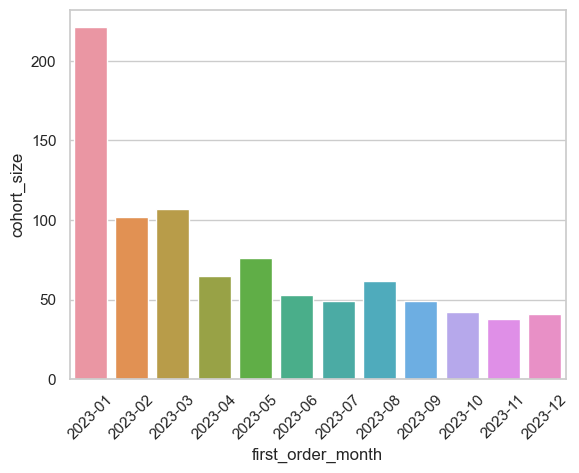

In [43]:
plt.xticks(rotation=45)
sns.barplot(data=cohort_sizes, x='first_order_month', y='cohort_size');

### 2
**Рассчитай средний доход с клиента для каждой когорты за 10 дней с момента их первой покупки.**

In [44]:
incomes_10_days = (
    df
    .groupby(['first_order_month', 'customer_id'])
    .income_10_days
    .min()
    .reset_index()
)
incomes_10_days.sample(5)

,first_order_month,customer_id,income_10_days
793,2023-10,789,8060.959352
104,2023-01,105,105451.509001
887,2023-12,913,45976.381012
743,2023-09,730,5162.941909
541,2023-05,553,11398.345106


In [45]:
mean_user_incomes_10_days = (
    incomes_10_days
    .groupby('first_order_month')
    .agg(
        cohort_size=('customer_id', 'nunique'), 
        mean_user_income_10_days=('income_10_days', 'mean')
    )
    .astype(int)
    .reset_index()
    [:12]
)
mean_user_incomes_10_days

,first_order_month,cohort_size,mean_user_income_10_days
0,2023-01,221,26887
1,2023-02,102,18287
2,2023-03,107,16892
3,2023-04,65,15577
4,2023-05,76,12584
5,2023-06,53,13001
6,2023-07,49,13160
7,2023-08,62,10310
8,2023-09,49,12478
9,2023-10,42,13372


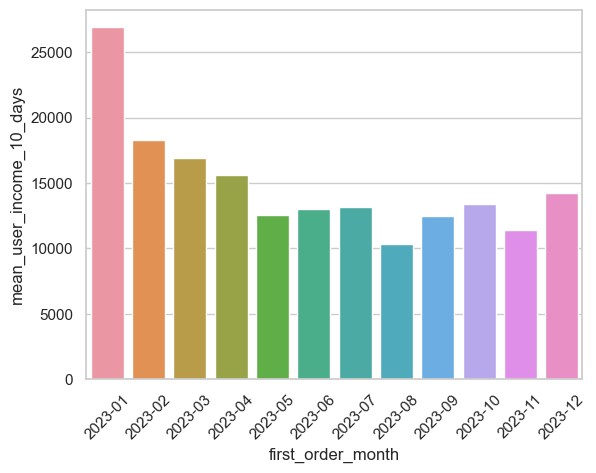

In [46]:
plt.xticks(rotation=45)
sns.barplot(data=mean_user_incomes_10_days, x='first_order_month', y='mean_user_income_10_days');
# sns.lmplot(data=mean_user_incomes_10_days, x='first_order_month', y='mean_user_income_10_days');

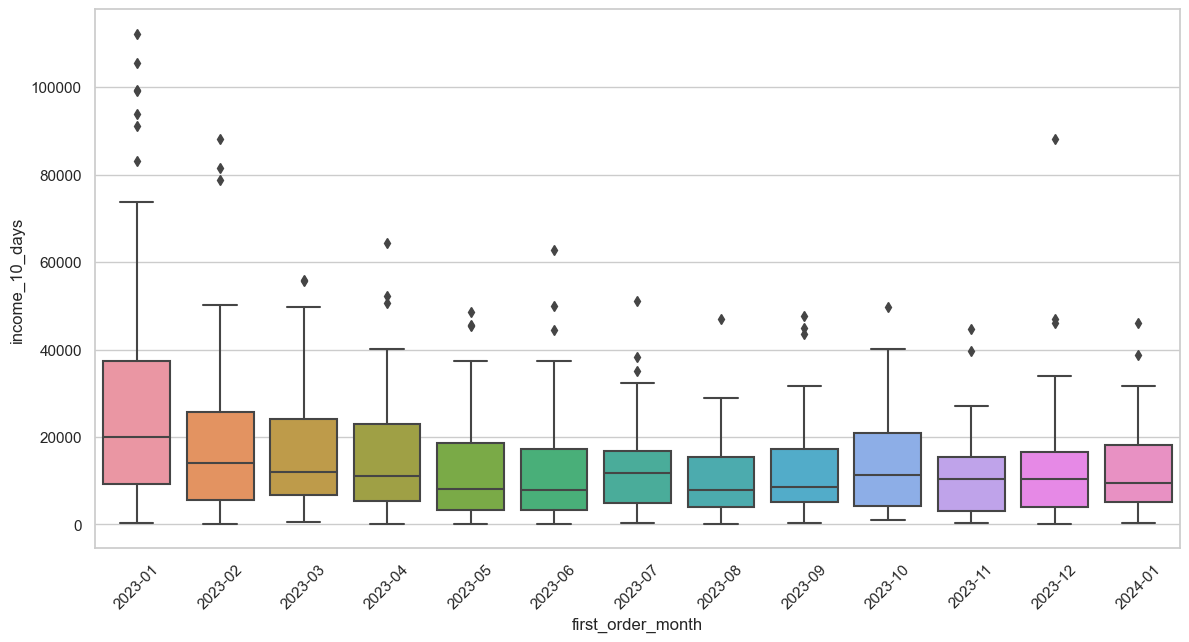

In [47]:
plt.figure(figsize=(14, 7))
plt.xticks(rotation=45)
sns.boxplot(data=incomes_10_days, y='income_10_days', x='first_order_month');

### 3
**Отобрази результаты по месяцам первых покупок, категориям товаров и платформам.**

Посчитаем поюзерное среднее по платформам

In [48]:
#  для каждого пользователя найдем сумму его заказов на каждой платформе
incomes_10_days_by_platform = (
    df[df.day_from_start < 10]
    .groupby(['customer_id', 'platform'])
    .order_amount
    .sum()
    .reset_index()
)
incomes_10_days_by_platform.columns = ['customer_id', 'platform', 'orders_sum']
incomes_10_days_by_platform.sample(5)

,customer_id,platform,orders_sum
659,220,shop,0.0
293,98,shop,0.0
2350,784,mobile,0.0
2692,908,mobile,0.0
1982,661,shop,0.0


In [49]:
# "словарь" с первыми месяцами для каждого пользователя
first_months = df[df.day_from_start < 10][['customer_id', 'first_order_month']].groupby('customer_id').min()
first_months.sample(5)

,first_order_month
customer_id,
921,2024-01
328,2023-03
820,2023-10
802,2023-09
308,2023-02


In [50]:
# приджойним данные по первым месяцам
incomes_10_days_by_platform_and_first_month = incomes_10_days_by_platform.join(first_months, on='customer_id')
incomes_10_days_by_platform_and_first_month.sample(5)

,customer_id,platform,orders_sum,first_order_month
845,282,shop,209.346681,2023-02
1287,430,desktop,0.000000,2023-04
1096,366,mobile,25163.323033,2023-03
1331,444,shop,0.000000,2023-03
2841,990,desktop,0.000000,2024-01


In [51]:
(
    incomes_10_days_by_platform_and_first_month
    .pivot_table('orders_sum', 'first_order_month', 'platform')
    .round()
    .astype(int)
    [:12].
    style.background_gradient()
)

platform,desktop,mobile,shop
first_order_month,,,
2023-01,8932,12854,5102
2023-02,6363,8429,3495
2023-03,5019,7685,4187
2023-04,5681,7079,2817
2023-05,3072,7094,2419
2023-06,4633,5073,3296
2023-07,4252,6372,2536
2023-08,3237,4610,2464
2023-09,3399,6936,2144


Если в расчете среднего дохода с клиента не надо учитывать категории товаров, в которых пользователь не сделал покупок, то поюзерные среднии будут больше:

In [52]:
(
    incomes_10_days_by_platform_and_first_month[incomes_10_days_by_platform_and_first_month.orders_sum!=0]
    .pivot_table('orders_sum', 'first_order_month', 'platform')
    .round()
    .astype(int)
    [:12].
    style.background_gradient()
)

platform,desktop,mobile,shop
first_order_month,,,
2023-01,16048,16612,12528
2023-02,13521,12832,12734
2023-03,12490,14427,13577
2023-04,13677,10003,15260
2023-05,8339,11981,9191
2023-06,9821,11202,11647
2023-07,10418,13010,9558
2023-08,8027,8407,7637
2023-09,8765,14776,7004


Посчитаем поюзерное среднее по категориям товаров

In [53]:
#  для каждого пользователя найдем сумму его заказов по каждой категории товаров
incomes_10_days_by_category = (
    df[df.day_from_start < 10]
    .groupby(['customer_id', 'category'])
    .order_amount
    .sum()
    .reset_index()
)
incomes_10_days_by_category.columns = ['customer_id', 'category', 'orders_sum']
incomes_10_days_by_category.sample(5)

,customer_id,category,orders_sum
384,129,laptops,4266.790978
1144,382,smartphones,4558.474209
2461,821,smartphones,10751.808030
2659,896,smartphones,15359.037911
719,240,watches,1546.656576


In [54]:
# приджойним данные по первым месяцам
incomes_10_days_by_category_and_first_month = incomes_10_days_by_category.join(first_months, on='customer_id')
incomes_10_days_by_category_and_first_month.sample(5)

,customer_id,category,orders_sum,first_order_month
331,111,smartphones,1384.699318,2023-01
1616,539,watches,0.000000,2023-05
114,39,laptops,3135.566787,2023-01
2657,895,watches,0.000000,2023-12
2204,735,watches,6602.014862,2023-09


In [55]:
(
    incomes_10_days_by_category_and_first_month
    .pivot_table('orders_sum', 'first_order_month', 'category')
    .round()
    .astype(int)
    [:12].
    style.background_gradient()
)

category,laptops,smartphones,watches
first_order_month,,,
2023-01,7054,13737,6097
2023-02,5748,9865,2673
2023-03,7434,7505,1954
2023-04,5030,8883,1665
2023-05,4009,6572,2003
2023-06,4492,4333,4176
2023-07,3841,7103,2216
2023-08,4059,4055,2196
2023-09,3678,6808,1992


Если в расчете среднего дохода с клиента не надо учитывать категории товаров, в которых пользователь не сделал покупок, то поюзерные среднии будут больше:

In [56]:
(
    incomes_10_days_by_category_and_first_month[incomes_10_days_by_category_and_first_month.orders_sum!=0]
    .pivot_table('orders_sum', 'first_order_month', 'category')
    .round()
    .astype(int)
    [:12].
    style.background_gradient()
)

category,laptops,smartphones,watches
first_order_month,,,
2023-01,13100,18399,14488
2023-02,13636,14584,8796
2023-03,14462,12746,9503
2023-04,10546,15194,7731
2023-05,10882,10406,8458
2023-06,11904,8834,13833
2023-07,11071,11227,10860
2023-08,8988,7395,8009
2023-09,9011,13344,7510


###### Experiments

In [31]:
df.order_date.dt.floor('d').sample()

1709   2023-03-06
Name: order_date, dtype: datetime64[ns]

floor работает с днями/часами/... Но не с годами/месяцами: поскольку "is a non-fixed frequency"

In [91]:
pt_by_customer = (
    df[df.day_from_start < 10]
    .groupby(['customer_id', 'first_order_month', 'platform', 'category'], as_index=False)
    .order_amount
    .sum()
    .dropna()
    .rename(columns={'order_amount': 'income_10_days'})
)
pt_by_customer.head()

,customer_id,first_order_month,platform,category,income_10_days
0,1,2023-01,desktop,laptops,0.000000
1,1,2023-01,desktop,smartphones,10163.013974
2,1,2023-01,desktop,watches,0.000000
3,1,2023-01,mobile,laptops,43207.644198
4,1,2023-01,mobile,smartphones,314.113705


In [94]:
pt = (
    pt_by_customer[pt_by_customer.income_10_days > 0]
    .groupby(['first_order_month', 'platform', 'category'])
    .income_10_days
    .agg('mean')
)
pt.head(10)

first_order_month  platform  category   
2023-01            desktop   laptops        11642.219032
                             smartphones    15177.695331
                             watches        11521.376718
                   mobile    laptops        11312.430670
                             smartphones    14139.336361
                             watches        11285.018798
                   shop      laptops         9187.405431
                             smartphones    10284.394510
                             watches        13530.652826
2023-02            desktop   laptops        13119.697068
Name: income_10_days, dtype: float64

In [81]:
df[(df.day_from_start < 10) & (df.first_order_month == '2023-01') & (df.platform == 'desktop') & (df.category == 'laptops')].income_10_days.mean()

31458.073162446195

In [21]:
df.sample(5)

,order_id,customer_id,order_date,order_amount,platform,category,order_day,first_order_month,day_from_start,income_10_days
1063,1064,151,2023-02-10 00:25:44.177203156,20305.979695,desktop,smartphones,2023-02-10,2023-01,28,NaN
9230,9231,408,2023-12-14 11:22:41.764426276,1093.217199,desktop,smartphones,2023-12-14,2023-04,250,NaN
4240,4241,182,2023-06-09 14:52:25.165890294,8797.854164,mobile,laptops,2023-06-09,2023-02,111,NaN
3281,3282,357,2023-05-04 12:24:34.360680674,4780.991583,shop,smartphones,2023-05-04,2023-03,60,NaN
6544,6545,377,2023-09-04 08:33:21.406977852,4184.219612,mobile,watches,2023-09-04,2023-03,184,NaN
